In [1]:
#Importing Modules and Keys
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt 
import numpy as np
import math
import gmaps
from scipy.stats import linregress
from config import hehe
gmaps.configure(api_key=hehe)
from pprint import pprint
from config import openWeatherKey


In [2]:
#Pulling First CSV and filtering for desired columns
weatherDisasterCSV = "Resources/disaster_data.csv"
wDisaster_df = pd.read_csv(weatherDisasterCSV)
desiredColumns = ["Dis No", "Year", "Seq", "Disaster Subgroup", "Disaster Type", "Disaster Subtype", "Disaster Subsubtype", "Entry Criteria", "ISO", "Location", "Start Month", "End Month", "Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)", "CPI"]
wDisaster_df = wDisaster_df.loc[wDisaster_df["ISO"] == "USA", desiredColumns]
#wDisaster_df

#Creating Data Fram with Location name and Disaster Number
newData = { "Location": [], "Dis No": []}
for index, row in wDisaster_df.iterrows():
    if type(row["Location"]) is str:
        for location in row["Location"].split(","):
            newData["Location"].append(location)
            newData["Dis No"].append(row["Dis No"])
splitLocations_df = pd.DataFrame(newData)
#splitLocations_df

#Adding Columns for Lat / Long
splitLocations_df["Lat"] = ""
splitLocations_df["Long"] = ""
locations = splitLocations_df["Location"]
#splitLocations_df

#Pulling Coordnates from CSV that we created using OpenWeather API
coordCSV = "output_data/NEW_coordinates.csv"
coordLocations_df = pd.read_csv(coordCSV)
cleanedCoordsIndex = coordLocations_df.index
coordLocations_df = coordLocations_df.loc[:, ['Location', 'Dis No', 'Lat', 'Long']]
#coordLocations_df

#MMerging my Data Frames
Combined_df =pd.merge(wDisaster_df, coordLocations_df, on='Dis No')
#Combined_df

#Creating my Database for the 1 Quintant (North East) by filtering for Lat / Long
FirstQuintant1 = Combined_df.loc[Combined_df["Lat"] > 38, :].reset_index(drop=True)
FirstQuintant2 = FirstQuintant1.loc[FirstQuintant1["Long"] > -90, :].reset_index(drop=True)
#FirstQuintant2

#Filtering for columns we want to use in analysis
desiredColumns = ["Dis No","Year", "Seq", "Disaster Subgroup", "Disaster Type", "Disaster Subtype", "Disaster Subsubtype", "Entry Criteria", "ISO", "Start Month", "End Month", "Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)", "CPI","Location_y","Lat","Long"]
FirstQuintant = FirstQuintant2.loc[:, desiredColumns].reset_index(drop=True)
FirstQuintant.rename(columns={'Location_y': 'Location'}, inplace=True)
#FirstQuintant

#Creating a trimmed DF of dropped duplicates for more accurate calculations
FirstQuintantUniqueForCalc = FirstQuintant.drop_duplicates(subset="Dis No", keep="first")
#FirstQuintantUniqueForCalc

#Filtering, grouping and changing the names of columns for yearly analysis
Yearly_TotalsRaw = FirstQuintantUniqueForCalc.groupby("Year").sum()
desiredColumns = ["Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)"]
Yearly_Totals = Yearly_TotalsRaw.loc[:, desiredColumns].reset_index(drop=False)
Yearly_Totals.rename(columns={"Insured Damages ('000 US$)" : "Insured Damages", "Total Damages ('000 US$)" : "Total Damages"}, inplace=True)
Yearly_CountRaw = FirstQuintantUniqueForCalc.groupby("Year").count()
Yearly_Count = Yearly_CountRaw.loc[:, "Dis No"].reset_index(drop=False)
YearlyMerged = pd.merge(Yearly_Count, Yearly_Totals, on='Year')
#YearlyMerged


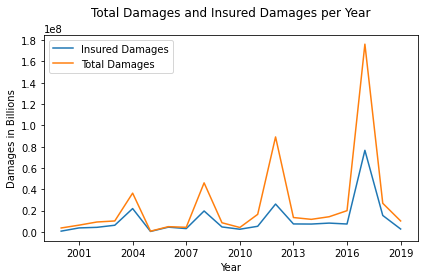

In [3]:
# Total Damanges and Insured Damanges per Year
PlotThis = ["Insured Damages","Total Damages"]
df = YearlyMerged
Damages = df.plot(kind="line",x="Year",y=PlotThis)
Damages.xaxis.set_major_locator(plt.MaxNLocator(8))
Damages.yaxis.set_major_locator(plt.MaxNLocator(10))
plt.ylabel('Damages in Billions')  
  
# displaying the title 
plt.title(label='Total Damages and Insured Damages per Year',  
          fontweight=10,  
          pad='2.0', y=1.08)
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NEDamages.png')

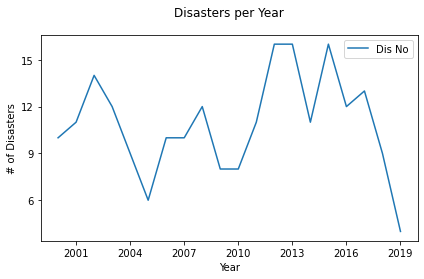

In [4]:
# Disasters per Year
PlotThis = ["Dis No"]
df = YearlyMerged
DisasterCount = df.plot(kind="line",x="Year",y=PlotThis)
DisasterCount.xaxis.set_major_locator(plt.MaxNLocator(8))
DisasterCount.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('# of Disasters')  
  
# displaying the title 
plt.title(label='Disasters per Year',  
          fontweight=10,  
          pad='2.0', y=1.08)
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NEDisasterCoun.png')

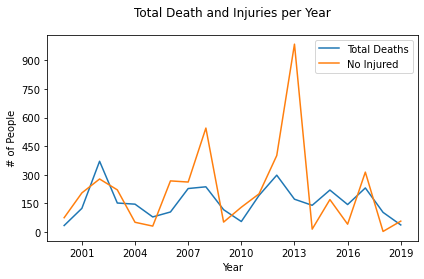

In [5]:
# Total Death and Injuries per Year
PlotThis = ["Total Deaths", "No Injured"]
df = YearlyMerged
DeathInjury = df.plot(kind="line",x="Year",y=PlotThis)
DeathInjury.xaxis.set_major_locator(plt.MaxNLocator(8))
DeathInjury.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Total Death and Injuries per Year',  
          fontweight=10,  
          pad='2.0', y=1.08)
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NEDeathInjury.png')

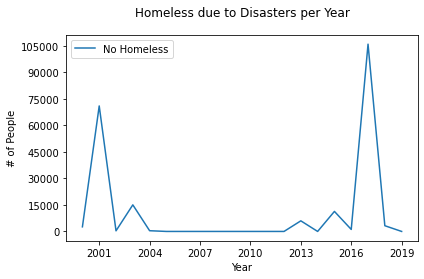

In [6]:
# Homeless due to Disasters per Year
PlotThis = ["No Homeless"]
df = YearlyMerged
Homeless = df.plot(kind="line",x="Year",y=PlotThis)
Homeless.xaxis.set_major_locator(plt.MaxNLocator(8))
Homeless.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Homeless due to Disasters per Year',  
          fontweight=10,  
          pad='2.0', y=1.08)
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NEHomeless.png')

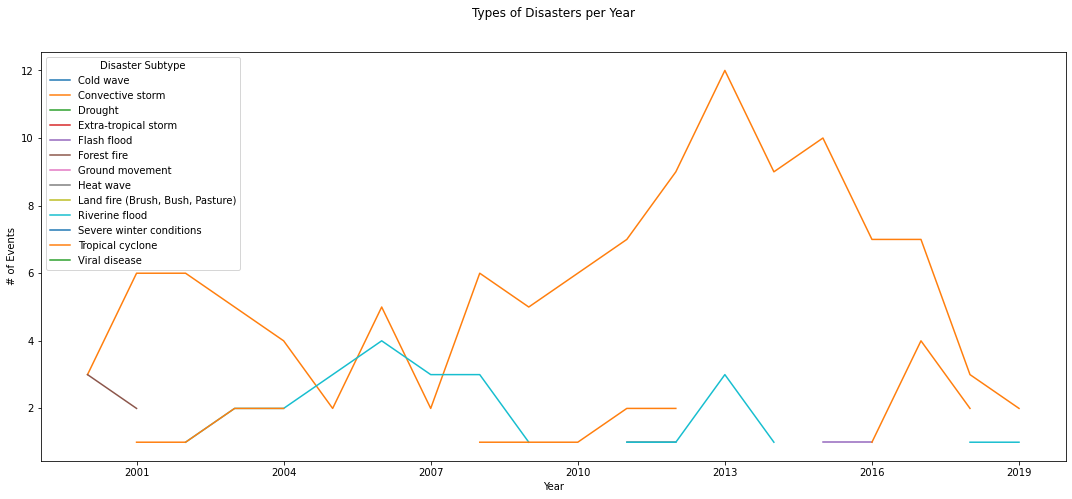

In [7]:
# Types of Disasters by Year
Types =  pd.DataFrame(FirstQuintantUniqueForCalc.groupby('Year')['Disaster Subtype'].value_counts())
df = Types
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
FirstQuintantUniqueForCalc.groupby('Year')['Disaster Subtype'].value_counts().unstack().plot(ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))

plt.ylabel('# of Events')  
  
# displaying the title 
plt.title(label='Types of Disasters per Year',  
          fontweight=10,  
          pad='2.0', y=1.08)
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NEtypePerYear.png')

In [8]:
# Leo's Disaster Type Analysis

In [9]:
areasAffected = len(FirstQuintant["Location"].unique())
#Distaster subtypes value counts into variables to use in the future 
regionDisTypesCount = FirstQuintant["Disaster Type"].value_counts()
regionDisSubTypeCount = FirstQuintant["Disaster Subtype"].value_counts()
#Print summary of total disaster count and areas affected
totalDisasterCount = len(FirstQuintantUniqueForCalc['Disaster Subtype'])
#DF for Total damages by subtype
regionalDisGroupby1 = FirstQuintantUniqueForCalc.groupby("Disaster Subtype").agg({"Location": "count", "Total Damages ('000 US$)" : "sum"})
#DF for Occurances of Disaster SubTypes plot
regionalDisGroupby = FirstQuintantUniqueForCalc.groupby(["Disaster Type", "Disaster Subtype"]).agg({"Location": "count", "Total Damages ('000 US$)" : "sum"})
#DF for Total affected by SubType
regionalDisGroupbyNoAff = FirstQuintantUniqueForCalc.groupby(["Disaster Subtype"]).agg({"No Homeless": "sum", "Total Deaths": "sum", "No Affected": "sum","Total Affected": "sum"})
regionalDisGroupbyNoAff = regionalDisGroupbyNoAff.drop(index="Drought")
#Print Message
print(f"There were {totalDisasterCount} total distaters in the Midwest Region\nThere {areasAffected} total areas affected")


There were 218 total distaters in the Midwest Region
There 156 total areas affected


In [10]:
#regionalDisGroupby

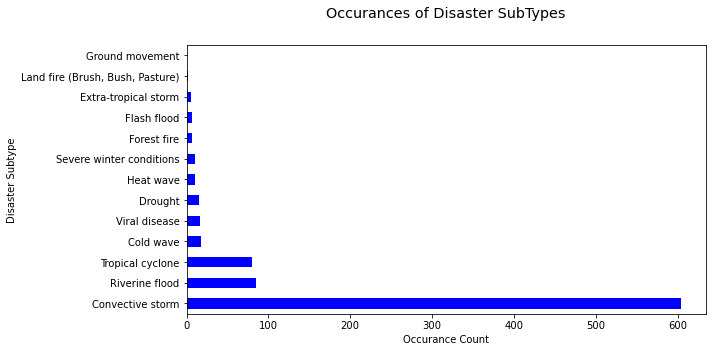

In [11]:
#Occurences by SubType
plt.figure(figsize=(10,5))

regionDisSubTypeCount.plot(kind="barh", facecolor="blue", rot=0)
plt.style.use('ggplot')
plt.title("Occurances of Disaster SubTypes", y=1.08)
plt.ylabel("Disaster Subtype")
plt.xlabel("Occurance Count")
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NEOccurancesofDisasterSubTypes.png')

<Figure size 720x720 with 0 Axes>

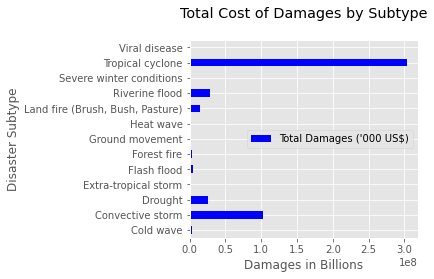

In [12]:
#Total damages by subtype
plt.figure(figsize=(10,10))

regionalDisGroupby1.plot(kind="barh", facecolor="blue", y="Total Damages ('000 US$)", rot=0)
plt.title("Total Cost of Damages by Subtype", y=1.08)
plt.ylabel("Disaster Subtype")
plt.xlabel("Damages in Billions")
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NETotalCostofDamagesbySubtype.png')

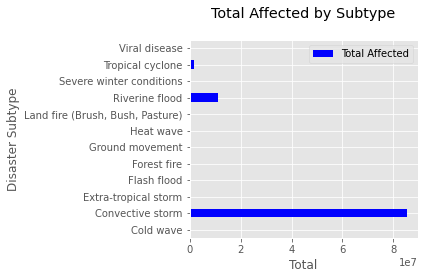

In [13]:
# Total affected by SubType
regionalDisGroupbyNoAff.plot.barh(use_index=True, y=["Total Affected"], rot=0, stacked=True, color={"blue": "Total Affected"})
plt.title("Total Affected by Subtype", y=1.08)
plt.ylabel("Disaster Subtype")
plt.xlabel("Total")
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NETotalAffectedbySubtype.png')

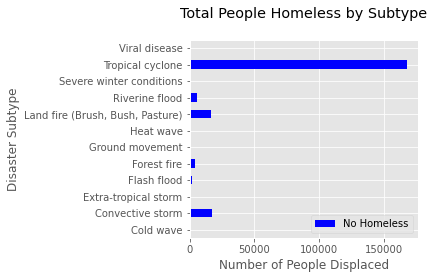

In [14]:
# Total Homeless by SubType
regionalDisGroupbyNoAff.plot.barh(use_index=True, y=["No Homeless"], rot=0, stacked=True, color={"blue": "No Homeless"})
plt.title("Total People Homeless by Subtype", y=1.08)
plt.ylabel("Disaster Subtype")
plt.xlabel("Number of People Displaced")
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NETotalPeopleHomelessbySubtype.png')

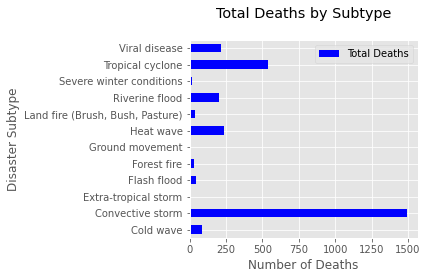

In [15]:
#Total Death by Subtype
regionalDisGroupbyNoAff.plot.barh(use_index=True, y=["Total Deaths"], rot=0, stacked=True, color={"blue": "Total Deaths"})
plt.title("Total Deaths by Subtype", y=1.08)
plt.ylabel("Disaster Subtype")
plt.xlabel("Number of Deaths")
plt.tight_layout()
#Exporting to folder
plt.savefig('output-graphs/NETotalDeathsbySubtype.png')

In [16]:
#South-East

In [17]:
trimmed_df = FirstQuintant.drop_duplicates(subset= "Dis No", keep="first")
Disastercount_df = trimmed_df.groupby(["Disaster Type", "Disaster Subtype"]).agg({"Location":"count","Total Damages ('000 US$)":"sum"})
locations = trimmed_df[["Lat", "Long"]]
ratings = trimmed_df["Total Damages ('000 US$)"].astype(float)
max_damages = max(trimmed_df["Total Damages ('000 US$)"])
year_list = trimmed_df["Year"].unique()
#year_list

yearly_max_dam = []
for year in year_list:
    yearly_df = trimmed_df.loc[trimmed_df["Year"] == year, ["Total Damages ('000 US$)"]].fillna(0)
    max_dam = max(yearly_df["Total Damages ('000 US$)"])
    yearly_max_dam.append(max_dam)  
#print(yearly_max_dam)

trimmed_year_df = trimmed_df.groupby(["Year"]).agg({"Total Damages ('000 US$)":"max"})
# trimmed_year_df = max(trimmed_year_df[trimmed_year_df["Total Damages ('000 US$)"]])

trimmed_year_df = trimmed_year_df.dropna()
trimmed_year_df["Max Dam"] = yearly_max_dam
#trimmed_year_df

In [18]:
trimmed_df.loc[trimmed_df["Year"] == 2019, ["Total Damages ('000 US$)"]]
trimmed_df["Total Damages ('000 US$)"].fillna(0)

0        166000.0
1        350000.0
3         28500.0
5             0.0
8             0.0
          ...    
939     5200000.0
941           0.0
942      235000.0
943    10000000.0
944           0.0
Name: Total Damages ('000 US$), Length: 218, dtype: float64

In [19]:
trimmed_year_df = trimmed_df.groupby(["Year"]).agg({"Total Damages ('000 US$)":"max"})
trimmed_year_df = trimmed_year_df.dropna()
trimmed_year_df
maxdamage_latlong_df = pd.merge(trimmed_year_df,trimmed_df, on=["Year","Total Damages ('000 US$)"], how="left")
maxdamage_latlong_df = maxdamage_latlong_df[["Year","Total Damages ('000 US$)","Location","Dis No","Lat","Long"]]
#maxdamage_latlong_df

locations1 = maxdamage_latlong_df[["Lat", "Long"]]
ratings1 = maxdamage_latlong_df["Total Damages ('000 US$)"].astype(float)
max_damages1 = max(maxdamage_latlong_df["Total Damages ('000 US$)"])

In [20]:
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights = ratings, dissipating=False, max_intensity=10000000,point_radius=1)
fig.add_layer(heat_layer)
fig
#Exporting to folder
#savefig('output-graphs/NEDisastersMapped.png')

Figure(layout=FigureLayout(height='420px'))

In [21]:
info_box_content = """
<dl>
<dt>Year</dt><dd>{Year}</dd>
<dt>Disaster Number</dt><dd>{Dis No}</dd>
<dt>Total Damages</dt><dd>{Total Damages ('000 US$)}</dd>
</dl>
"""
year_info = [info_box_content.format(**row) for index, row in maxdamage_latlong_df.iterrows()]
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
locations1 = maxdamage_latlong_df[["Lat", "Long"]]
#Add marker to heat map
markers = gmaps.marker_layer(locations1,info_box_content=year_info)
fig.add_layer(markers)
fig
#multiply by 1000
#Exporting to folder
#savefig('output-graphs/NECostlyDisastersMapped.png')

Figure(layout=FigureLayout(height='420px'))

In [22]:
#Mid-West

In [23]:
disasterdataCSV = "Resources/disaster_data.csv"
Data_disaster_df = pd.read_csv(disasterdataCSV)
# Data_disaster_df

weatherDisasterSouth_EastCSV = "output_data/NEW_coordinates.csv"
wDisaster_df = pd.read_csv(weatherDisasterSouth_EastCSV)
# wDisaster_df

SE_wDisaster_df = wDisaster_df.loc[(wDisaster_df["Long"]>-90) & (wDisaster_df["Lat"]<38),["Location","Dis No","Lat", "Long"]]
# SE_wDisaster_df

SE_Data_list_df = pd.merge(SE_wDisaster_df, Data_disaster_df, on="Dis No", how="left").rename(columns={"Location_x": "Location"})
# SE_Data_list_df

SE_Data_list_df["Disaster Type"].unique()

trimmed_df = SE_Data_list_df.drop_duplicates(subset= "Dis No", keep="first")
# trimmed_df

Disastercount_df = trimmed_df.groupby(["Disaster Subtype"]).agg({"Location":"count","Total Deaths":"sum","No Injured":"sum","No Affected":"sum","No Homeless":"sum",
                                           "Total Affected":"sum","Insured Damages ('000 US$)":"sum","Total Damages ('000 US$)":"sum"})
# Disastercount_df = trimmed_df.groupby(["Disaster Subtype"]).sum(["Location"])
Disastercount_df = Disastercount_df.reset_index(drop=False)
# Disastercount_df


#Total covered by Insuance
insurance_coverage = trimmed_df.groupby(["Year","Dis No"]).sum()
keycolumns = ["Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)"]
insurance_coverage = insurance_coverage.loc[:,keycolumns].reset_index(drop=False)
# insurance_coverage

DesiredColumn = desiredColumns = ["Dis No","Total Deaths", "No Injured", "No Affected", "No Homeless", 
                                  "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)"]
insurance = trimmed_df.groupby("Year").agg({"Dis No":"count","Total Deaths":"sum","No Injured":"sum","No Affected":"sum","No Homeless":"sum",
                                           "Total Affected":"sum","Insured Damages ('000 US$)":"sum","Total Damages ('000 US$)":"sum"})
insurance = insurance.loc[:,desiredColumns].reset_index(drop=False)

([<matplotlib.axis.XTick at 0x27177f86f60>,
 [Text(0, 0, 'Cold wave'),
  Text(0, 0, 'Convective storm'),
  Text(0, 0, 'Drought'),
  Text(0, 0, 'Flash flood'),
  Text(0, 0, 'Forest fire'),
  Text(0, 0, 'Heat wave'),
  Text(0, 0, 'Land fire (Brush, Bush, Pasture)'),
  Text(0, 0, 'Riverine flood'),
  Text(0, 0, 'Severe winter conditions'),
  Text(0, 0, 'Tropical cyclone'),
  Text(0, 0, 'Viral disease')])

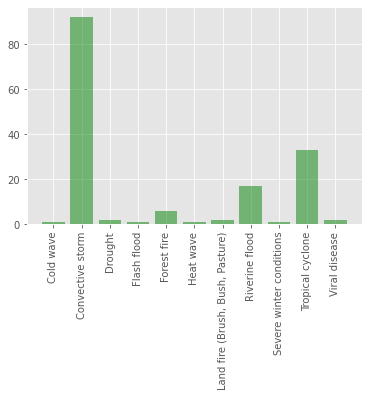

In [24]:
#Counts of Disasters
xaxis = np.arange(len(Disastercount_df))
tick_locations = [value for value in xaxis]
yaxis = Disastercount_df["Location"]
plt.bar(xaxis, yaxis, color='g', alpha=0.5, align="center")
plt.style.use("ggplot")
plt.xticks(tick_locations, Disastercount_df["Disaster Subtype"], rotation= "vertical")

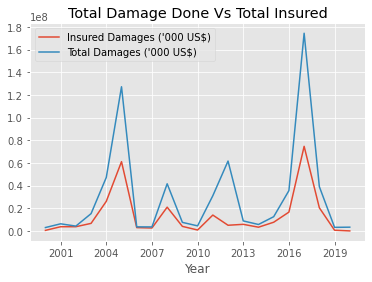

In [25]:
# Total Damanges and Insured Damanges
PlotThis = ["Insured Damages ('000 US$)","Total Damages ('000 US$)"]
df = insurance
lines = df.plot(kind="line",x="Year",y=PlotThis)
lines.xaxis.set_major_locator(plt.MaxNLocator(8))
lines.yaxis.set_major_locator(plt.MaxNLocator(10))
plt.title("Total Damage Done Vs Total Insured")
plt.savefig("output-graphs/SE_total_dam_tot_insured.png")

Text(0.5, 1.0, 'Disaster count')

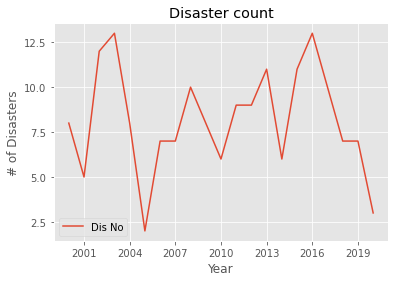

In [26]:
# Disasters per Year
PlotThis = ["Dis No"]
df = insurance
Dis_count = insurance.plot(kind="line",x="Year",y=PlotThis)
Dis_count.xaxis.set_major_locator(plt.MaxNLocator(8))
Dis_count.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('# of Disasters')  
plt.savefig("output-graphs/SE_Disaster_count.png")
  
# displaying the title 
plt.title("Disaster count")

Text(0.5, 1.0, 'Total Death and Injuries per Year')

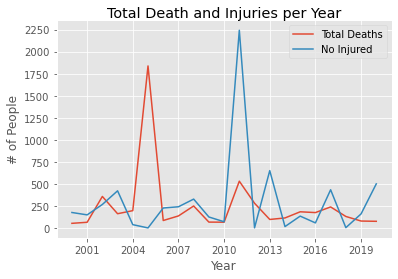

In [27]:
# Total Death and Injuries per Year
PlotThis = ["Total Deaths", "No Injured"]
df = insurance
DeathInjury = df.plot(kind="line",x="Year",y=PlotThis)
DeathInjury.xaxis.set_major_locator(plt.MaxNLocator(8))
DeathInjury.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
plt.savefig("output-graphs/SE_total_death_count.png")

  
# displaying the title 
plt.title(label='Total Death and Injuries per Year',  
          fontweight=10,  
          pad='2.0')

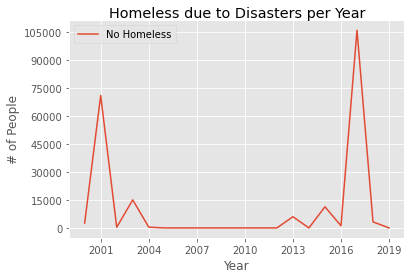

In [28]:
# Homeless due to Disasters per Year
PlotThis = ["No Homeless"]
df = YearlyMerged
Homeless = df.plot(kind="line",x="Year",y=PlotThis)
Homeless.xaxis.set_major_locator(plt.MaxNLocator(8))
Homeless.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Homeless due to Disasters per Year',  
          fontweight=10,  
          pad='2.0')
plt.savefig("output-graphs/SE_total_homeless_count.png")


Text(0.5, 1.0, 'Types of Disasters per Year')

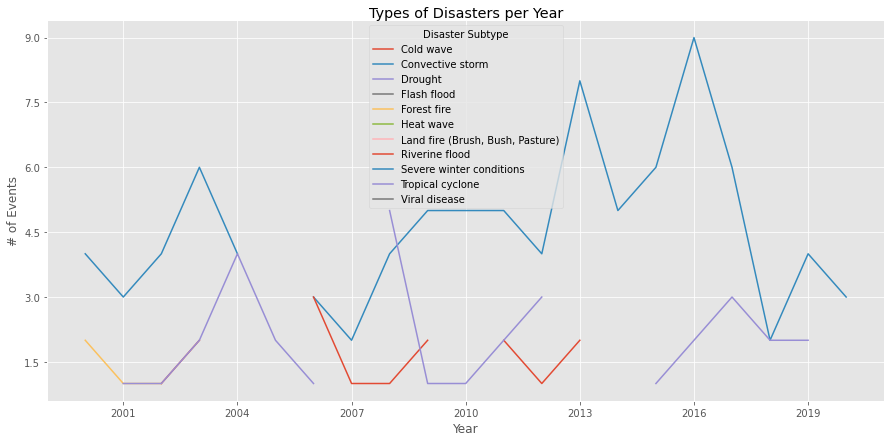

In [29]:
# Types of Disasters by Year
Types =  pd.DataFrame(trimmed_df.groupby('Year')['Disaster Subtype'].value_counts())
df = Types
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
trimmed_df.groupby('Year')['Disaster Subtype'].value_counts().unstack().plot(ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))

plt.ylabel('# of Events')  
  
# displaying the title 
plt.title(label='Types of Disasters per Year',  
          fontweight=10,  
          pad='2.0')

In [30]:
Disastercount_df = trimmed_df.groupby(["Disaster Type", "Disaster Subtype"]).agg({"Location":"count","Total Damages ('000 US$)":"sum"})
locations = trimmed_df[["Lat", "Long"]]
ratings = trimmed_df["Total Damages ('000 US$)"].astype(float)
max_damages = max(trimmed_df["Total Damages ('000 US$)"])
year_list = trimmed_df["Year"].unique()
#year_list

yearly_max_dam = []
for year in year_list:
    yearly_df = trimmed_df.loc[trimmed_df["Year"] == year, ["Total Damages ('000 US$)"]].fillna(0)
    max_dam = max(yearly_df["Total Damages ('000 US$)"])
    yearly_max_dam.append(max_dam)  
#print(yearly_max_dam)

trimmed_year_df = trimmed_df.groupby(["Year"]).agg({"Total Damages ('000 US$)":"max"})
# trimmed_year_df = max(trimmed_year_df[trimmed_year_df["Total Damages ('000 US$)"]])

trimmed_year_df = trimmed_year_df.dropna()
trimmed_year_df["Max Dam"] = yearly_max_dam
#trimmed_year_df

In [31]:
trimmed_df.loc[trimmed_df["Year"] == 2019, ["Total Damages ('000 US$)"]]
trimmed_df["Total Damages ('000 US$)"].fillna(0)

0       350000.0
6            0.0
8        28500.0
9            0.0
14      500000.0
         ...    
562     600000.0
563    1200000.0
568    1000000.0
574    1200000.0
577    1100000.0
Name: Total Damages ('000 US$), Length: 172, dtype: float64

In [32]:
trimmed_year_df = trimmed_df.groupby(["Year"]).agg({"Total Damages ('000 US$)":"max"})
trimmed_year_df = trimmed_year_df.dropna()
trimmed_year_df
maxdamage_latlong_df = pd.merge(trimmed_year_df,trimmed_df, on=["Year","Total Damages ('000 US$)"], how="left")
maxdamage_latlong_df = maxdamage_latlong_df[["Year","Total Damages ('000 US$)","Location","Dis No","Lat","Long"]]
#maxdamage_latlong_df

locations1 = maxdamage_latlong_df[["Lat", "Long"]]
ratings1 = maxdamage_latlong_df["Total Damages ('000 US$)"].astype(float)
max_damages1 = max(maxdamage_latlong_df["Total Damages ('000 US$)"])

In [33]:
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights = ratings, dissipating=False, max_intensity=10000000,point_radius=1)
fig.add_layer(heat_layer)
plt.savefig("output-graphs/SE_Disaster_map.png")
fig

Figure(layout=FigureLayout(height='420px'))

<Figure size 432x288 with 0 Axes>

In [34]:
locations1 = maxdamage_latlong_df[["Lat", "Long"]]
ratings1 = maxdamage_latlong_df["Total Damages ('000 US$)"].astype(float)
max_damages1 = max(maxdamage_latlong_df["Total Damages ('000 US$)"])

In [35]:
# Using the template add the hotel marks to the heatmap
info_box_content = """
<dt>Year</dt><dd>{Year}</dd>
<dt>Disaster Number</dt><dd>{Dis No}</dd>
<dt>Total Damages</dt><dd>{Total Damages ('000 US$)}</dd>
</dl>
"""
year_info = [info_box_content.format(**row) for index, row in maxdamage_latlong_df.iterrows()]
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
year_info = [info_box_content.format(**row) for index, row in maxdamage_latlong_df.iterrows()]
locations1 = maxdamage_latlong_df[["Lat", "Long"]]


#Add marker to heat map
markers = gmaps.marker_layer(locations1,info_box_content=year_info)
fig.add_layer(markers)
plt.savefig("output-graphs/SE_Disaster_toptwentymap.png")

fig

Figure(layout=FigureLayout(height='420px'))

<Figure size 432x288 with 0 Axes>

In [37]:
weatherDisasterCSV = "Resources/disaster_data.csv"
coordCSV = "output_data/NEW_coordinates.csv"
wDisaster_df = pd.read_csv(weatherDisasterCSV)
coordLocations_df = pd.read_csv(coordCSV)
desiredColumns = ["Dis No", "Year", "Seq", "Disaster Subgroup", "Disaster Type", "Disaster Subtype", "Disaster Subsubtype", "Entry Criteria", "ISO", "Location", "Start Month", "End Month", "Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)", "CPI"]
wDisaster_df = wDisaster_df.loc[wDisaster_df["ISO"] == "USA", desiredColumns]
coordLocations_df = coordLocations_df.loc[:, ["Location", "Dis No", "Lat", "Long"]]

#Combining DFs
combinedData = pd.merge(coordLocations_df, wDisaster_df, on="Dis No", how="outer")
combinedData = combinedData.iloc[range(0,2861), :].rename(columns={"Location_x": "Location"})
thirdQuintant = combinedData.loc[(combinedData["Long"] < -90) & (combinedData["Long"] > -105), :]

#Creating a trimmed DF of dropped duplicates for more accurate calculations
uniqueDisNo_df = thirdQuintant.drop_duplicates(subset="Dis No", keep="first")

#My regions unique DF for plotting
uniqueThirdQuintant = uniqueDisNo_df.loc[(uniqueDisNo_df["Long"] < -90) & (uniqueDisNo_df["Long"] > -105), :]

In [38]:
areasAffected = len(thirdQuintant["Location"].unique())
#Distaster subtypes value counts into variables to use in the future 
regionDisTypesCount = uniqueThirdQuintant["Disaster Type"].value_counts()
regionDisSubTypeCount = uniqueThirdQuintant["Disaster Subtype"].value_counts()
#Print summary of total disaster count and areas affected
totalDisasterCount = len(uniqueThirdQuintant['Disaster Subtype'])
print(f"There were {totalDisasterCount} total distaters in the Midwest Region\nThere {areasAffected} total areas affected")

There were 232 total distaters in the Midwest Region
There 162 total areas affected


In [39]:
#DF for Occurances of Disaster SubTypes plot
regionalDisGroupby = uniqueThirdQuintant.groupby(["Disaster Type", "Disaster Subtype"]).agg({"Location": "count", "Total Damages ('000 US$)" : "sum"})

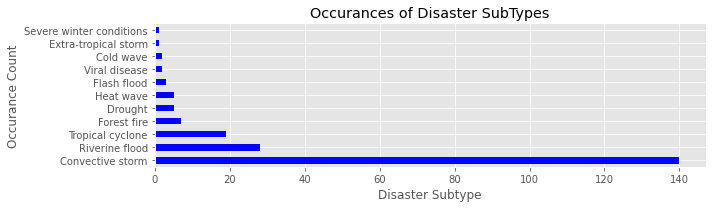

In [40]:
plt.figure(figsize=(10,3))
plt.style.use('ggplot')
regionDisSubTypeCount.plot(kind="barh", facecolor="blue")
plt.title("Occurances of Disaster SubTypes")
plt.xlabel("Disaster Subtype")
plt.ylabel("Occurance Count")
plt.tight_layout()
plt.savefig("output-graphs/MWDisasterOccurances.png")

<Figure size 720x720 with 0 Axes>

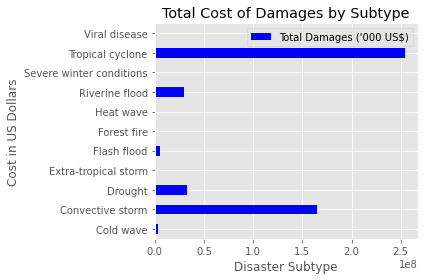

In [41]:
#Total damages by subtype
regionalDisGroupby1 = uniqueThirdQuintant.groupby("Disaster Subtype").agg({"Location": "count", "Total Damages ('000 US$)" : "sum"})

plt.figure(figsize=(10,10))

regionalDisGroupby1.plot(kind="barh", facecolor="blue", y="Total Damages ('000 US$)")
plt.title("Total Cost of Damages by Subtype")
plt.xlabel("Disaster Subtype")
plt.ylabel("Cost in US Dollars")
plt.tight_layout()
plt.savefig("output-graphs/MWDisasterDamages.png")

In [42]:
regionalDisGroupbyNoAff = uniqueThirdQuintant.groupby(["Disaster Subtype"]).agg({"No Homeless": "sum", "Total Deaths": "sum", "No Affected": "sum","Total Affected": "sum"})
regionalDisGroupbyNoAff = regionalDisGroupbyNoAff.drop(index="Drought")

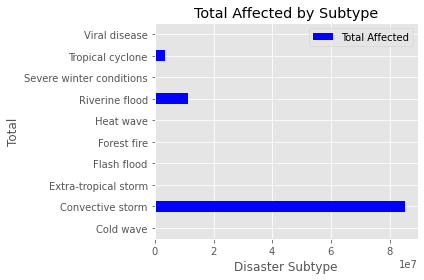

In [43]:
regionalDisGroupbyNoAff.plot.barh(use_index=True, y=["Total Affected"], stacked=True, color={"blue": "Total Affected"})
plt.title("Total Affected by Subtype")
plt.xlabel("Disaster Subtype")
plt.ylabel("Total")
plt.tight_layout()
plt.savefig("output-graphs/MWTotalAffected.png")

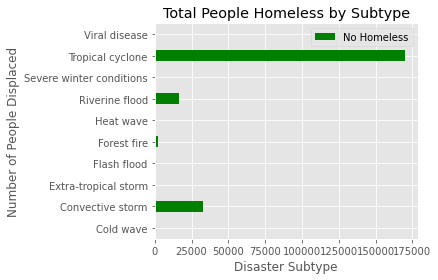

In [44]:
regionalDisGroupbyNoAff.plot.barh(use_index=True, y=["No Homeless"], stacked=True, color={"green": "No Homeless"})
plt.title("Total People Homeless by Subtype")
plt.xlabel("Disaster Subtype")
plt.ylabel("Number of People Displaced")
plt.tight_layout()
plt.savefig("output-graphs/MWNumberDisplaced.png")

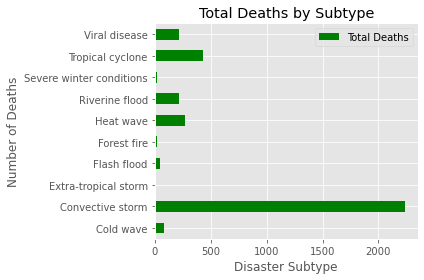

In [45]:
regionalDisGroupbyNoAff.plot.barh(use_index=True, y=["Total Deaths"], stacked=True, color={"green": "Total Deaths"})
plt.title("Total Deaths by Subtype")
plt.xlabel("Disaster Subtype")
plt.ylabel("Number of Deaths")
plt.tight_layout()
plt.savefig("output-graphs/MWNumberOfDeaths.png")

In [46]:
Yearly_TotalsRaw = uniqueThirdQuintant.groupby("Year").sum()
desiredColumns = ["Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)"]
Yearly_Totals = Yearly_TotalsRaw.loc[:, desiredColumns].reset_index(drop=False)
Yearly_Totals.rename(columns={"Insured Damages ('000 US$)" : "Insured Damages", "Total Damages ('000 US$)" : "Total Damages"}, inplace=True)
Yearly_CountRaw = uniqueThirdQuintant.groupby("Year").count()
Yearly_Count = Yearly_CountRaw.loc[:, "Dis No"].reset_index(drop=False)
YearlyMerged = pd.merge(Yearly_Count, Yearly_Totals, on='Year')
YearlyMerged.head()

,Year,Dis No,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Insured Damages,Total Damages
0,2000,12,138.0,146.0,17149.0,3165.0,20460.0,681000.0,2917500.0
1,2001,7,103.0,18.0,107240.0,70048.0,177306.0,3500000.0,6036000.0
2,2002,16,405.0,266.0,165102.0,351.0,165719.0,4653500.0,10551000.0
3,2003,11,146.0,421.0,2545.0,15186.0,18152.0,4972000.0,11884400.0
4,2004,9,155.0,57.0,43640.0,753.0,44450.0,21250000.0,36160170.0


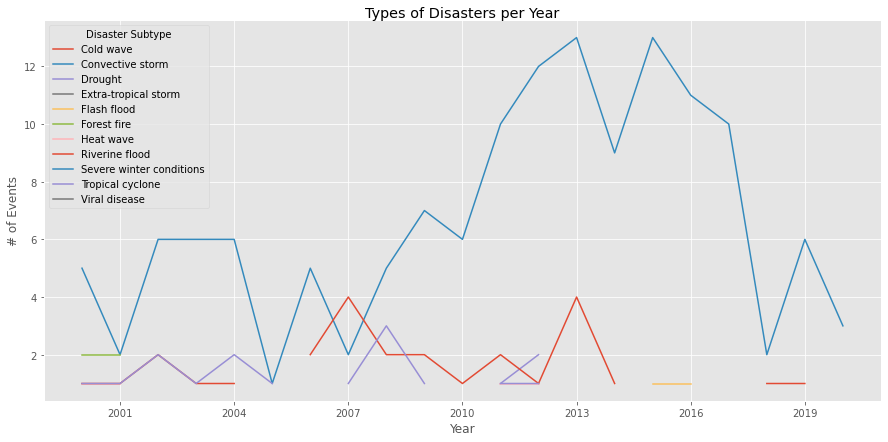

In [47]:
# Types of Disasters by Year
Types =  pd.DataFrame(uniqueThirdQuintant.groupby('Year')['Disaster Subtype'].value_counts())
df = Types
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
uniqueThirdQuintant.groupby('Year')['Disaster Subtype'].value_counts().unstack().plot(ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
plt.ylabel('# of Events')
# displaying the title
plt.title(label='Types of Disasters per Year',
          fontweight=10,
          pad='2.0')
plt.savefig("output-graphs/MWYearlyDisCountByYear.png")

Text(0.5, 1.0, 'Total Damanges and Insured Damanges per Year')

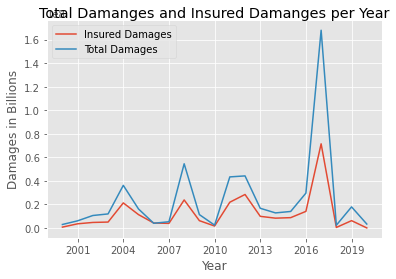

In [48]:
# Total Damanges and Insured Damanges per Year
PlotThis = ["Insured Damages","Total Damages"]
df = YearlyMerged
Damages = df.plot(kind="line",x="Year",y=PlotThis)
Damages.xaxis.set_major_locator(plt.MaxNLocator(8))
Damages.yaxis.set_major_locator(plt.MaxNLocator(10))
plt.ylabel('Damages in Billions')  
  
# displaying the title 
plt.title(label='Total Damanges and Insured Damanges per Year',  
          fontweight=10,  
          pad='2.0')

Text(0.5, 1.0, 'Disasters per Year')

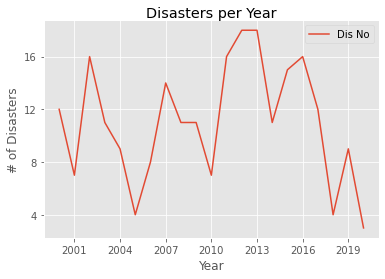

In [49]:
# Disasters per Year
PlotThis = ["Dis No"]
df = YearlyMerged
Homeless = df.plot(kind="line",x="Year",y=PlotThis)
Homeless.xaxis.set_major_locator(plt.MaxNLocator(8))
Homeless.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('# of Disasters')  
  
# displaying the title 
plt.title(label='Disasters per Year',  
          fontweight=10,  
          pad='2.0')

Text(0.5, 1.0, 'Total Death and Injuries per Year')

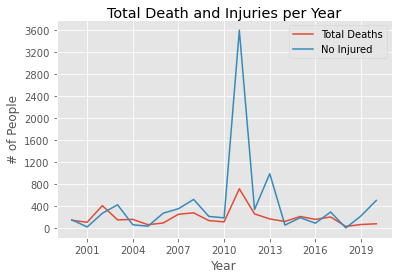

In [50]:
# Total Death and Injuries per Year
PlotThis = ["Total Deaths", "No Injured"]
df = YearlyMerged
DeathInjury = df.plot(kind="line",x="Year",y=PlotThis)
DeathInjury.xaxis.set_major_locator(plt.MaxNLocator(8))
DeathInjury.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Total Death and Injuries per Year',  
          fontweight=10,  
          pad='2.0')


Text(0.5, 1.0, 'Homeless due to Disasters per Year')

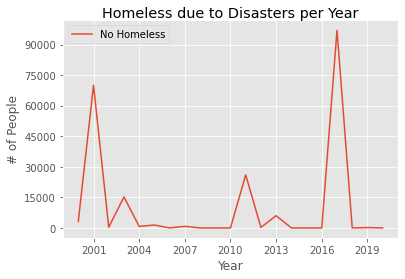

In [51]:
# Homeless due to Disasters per Year
PlotThis = ["No Homeless"]
df = YearlyMerged
Homeless = df.plot(kind="line",x="Year",y=PlotThis)
Homeless.xaxis.set_major_locator(plt.MaxNLocator(8))
Homeless.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Homeless due to Disasters per Year',  
          fontweight=10,  
          pad='2.0')

In [52]:
locations = uniqueThirdQuintant[["Lat", "Long"]]
ratings = uniqueThirdQuintant["Total Damages ('000 US$)"].astype(float)
max_damages = max(uniqueThirdQuintant["Total Damages ('000 US$)"].fillna(0))

In [53]:
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights = ratings, dissipating=False, max_intensity=max_damages,
                                 point_radius=1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [54]:
year_list = uniqueThirdQuintant["Year"].unique()
yearly_max_dam = []
for year in year_list:
    yearly_df = uniqueThirdQuintant.loc[uniqueThirdQuintant["Year"] == year, ["Total Damages ('000 US$)"]].fillna(0)
    max_dam = max(yearly_df["Total Damages ('000 US$)"])
    yearly_max_dam.append(max_dam)

In [61]:
trimmed_year_df = uniqueThirdQuintant.groupby(["Year"]).agg({"Total Damages ('000 US$)":"max"})
# trimmed_year_df = max(trimmed_year_df[trimmed_year_df["Total Damages ('000 US$)"]])
trimmed_year_df = trimmed_year_df.dropna()
trimmed_year_df["Max Dam"]= yearly_max_dam

In [56]:
maxdamage_latlong_df = pd.merge(trimmed_year_df,uniqueThirdQuintant, on=["Year","Total Damages ('000 US$)"], how="left")
maxdamage_latlong_df = maxdamage_latlong_df[["Year","Total Damages ('000 US$)","Location","Dis No","Lat","Long"]]

locations1 = maxdamage_latlong_df[["Lat", "Long"]]
ratings1 = maxdamage_latlong_df["Total Damages ('000 US$)"].astype(float)
max_damages1 = max(maxdamage_latlong_df["Total Damages ('000 US$)"])

In [57]:
info_box_content = """
<dl>
<dt>Year</dt><dd>{Year}</dd>
<dt>Disaster Number</dt><dd>{Dis No}</dd>
<dt>Total Damages</dt><dd>{Total Damages ('000 US$)}</dd>
</dl>
"""
year_info = [info_box_content.format(**row) for index, row in maxdamage_latlong_df.iterrows()]
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
locations1 = maxdamage_latlong_df[["Lat", "Long"]]
#Add marker to heat map
markers = gmaps.marker_layer(locations1,info_box_content=year_info)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))